In [18]:
import random
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from numpy import interp
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from collections import defaultdict


In [19]:
input_data_dir = "data"
output_dir = "results"

os.makedirs(output_dir, exist_ok=True)

disease_name = pd.read_csv(os.path.join(input_data_dir, 'disease_name.csv'),header=None)
snoRNA_name = pd.read_csv(os.path.join(input_data_dir, 'snoRNA_name.csv'),header=None)
SnoRNA_similarity = pd.read_csv(os.path.join(output_dir, 'KS_matrix.csv'), header=None)
known_association = pd.read_csv(os.path.join(input_data_dir, 'known_snoRNA_disease.csv'), header=None)
disease_similarity = pd.read_csv(os.path.join(output_dir, 'KD_matrix.csv'), header=None)



disease_semantic_similarity = np.zeros(disease_similarity.shape) 
snoRNA_functional_similarity = np.zeros(SnoRNA_similarity.shape) 
adjacency_matrix = np.zeros(known_association.shape) 




In [20]:
disease_name.shape , snoRNA_name.shape , SnoRNA_similarity.shape , known_association.shape , disease_similarity.shape

((112, 2), (335, 1), (335, 335), (335, 112), (112, 112))

In [21]:
def test(a):
        
    if(type(a)==list):
        return("length:",len(a)," sample length:",len(a[0]))
    elif(type(a)==np.ndarray):
        return("shape:",a.shape," sample length:",a[0].shape())
    else:
        return("type:",type(a)," sample:",a.iloc[0])
        

In [22]:
disease_semantic_similarity = disease_similarity.values
snoRNA_functional_similarity = SnoRNA_similarity.values
adjacency_matrix = known_association.values

In [23]:
adjacency_matrix.shape , disease_semantic_similarity.shape , snoRNA_functional_similarity.shape

((335, 112), (112, 112), (335, 335))

In [24]:
unknown = []
known = []
for x in range(known_association.shape[0]):
    for y in range(known_association.shape[1]):
        if adjacency_matrix[x, y] == 0:
            unknown.append((x, y))
        else:
            known.append((x, y))

         
major = []
for z in range(len(unknown)):
    a = disease_semantic_similarity[unknown[z][1], :].tolist()
    b = snoRNA_functional_similarity[unknown[z][0], :].tolist()
    q = a + b
    major.append(q) 

In [25]:
len(unknown), len(known), len(major)

(36510, 1010, 36510)

In [26]:
n_clusters = 23
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(major)
labels = kmeans.labels_

disease_rna_tup = defaultdict(list)
for (rna, dis), label in zip(unknown, labels):
    disease_rna_tup[label].append((rna, dis))



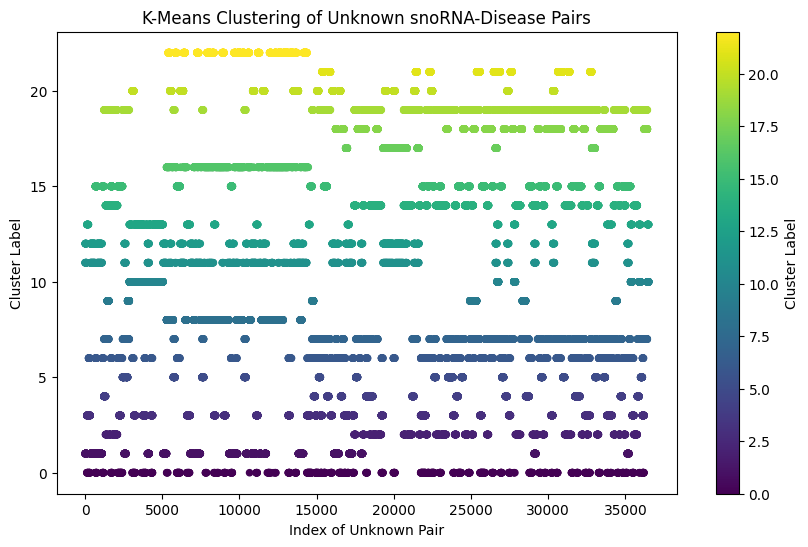

In [27]:
plt.figure(figsize=(10, 6))
plt.scatter(range(len(labels)), labels, c=labels, cmap='viridis', s=20)
plt.title('K-Means Clustering of Unknown snoRNA-Disease Pairs')
plt.xlabel('Index of Unknown Pair')
plt.ylabel('Cluster Label')
plt.colorbar(label='Cluster Label')
plt.show()

In [28]:
print("Final datasets are being prepared now..")
sampled_disease_rna_tup = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
n = 0
for i in range(len(disease_rna_tup)):
    sampled_disease_rna_tup[i] = random.sample(disease_rna_tup[i], int((len(disease_rna_tup[i])/len(labels)) * len(known)))

dataset = []
for rna in range(known_association.shape[0]):
    for disease in range(known_association.shape[1]):
        for i in range(len(sampled_disease_rna_tup)):
            if (rna, disease) in sampled_disease_rna_tup[i]:
                dataset.append((rna, disease))


for rna in range(known_association.shape[0]):
    for disease in range(known_association.shape[1]):
        if (rna, disease) in known:
            dataset.append((rna, disease))

length = len(dataset)
print(length)


Final datasets are being prepared now..
2008


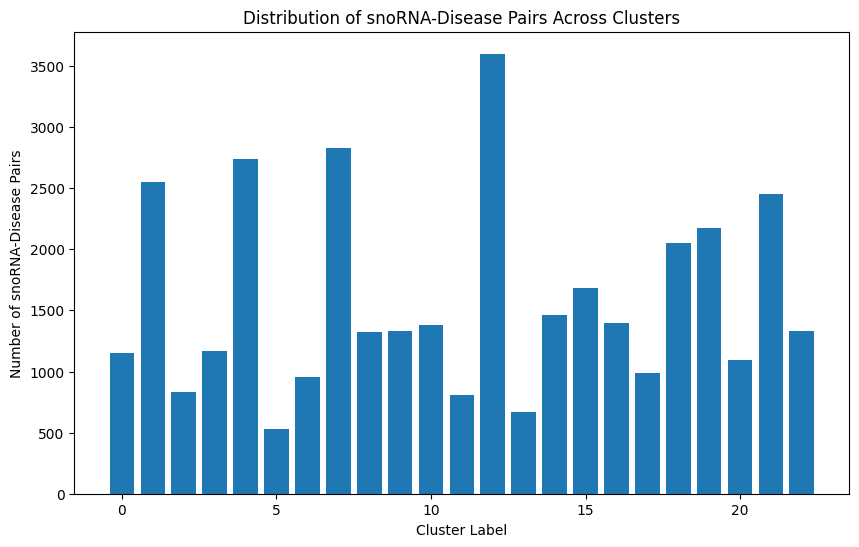

In [29]:
plt.figure(figsize=(10, 6))
plt.bar(range(n_clusters), [len(cluster) for cluster in disease_rna_tup.values()])
plt.xlabel('Cluster Label')
plt.ylabel('Number of snoRNA-Disease Pairs')
plt.title('Distribution of snoRNA-Disease Pairs Across Clusters')
plt.show()

In [30]:
selected_x = []
selected_y = []
#now I am just taking only the similarities of disease and rna of sampled data.
for data in dataset:
    a = disease_semantic_similarity[data[1], :].tolist()
    b = snoRNA_functional_similarity[data[0], :].tolist()
    q = a + b
    selected_x.append(q)

    if (data[0], data[1]) in known:
        selected_y.append(1)
    else:
        selected_y.append(0)

selected_data_np = np.array(selected_x)
selected_label_np = np.array(selected_y)



In [31]:
GBDT = GradientBoostingClassifier(n_estimators=12, max_depth=5, min_samples_leaf=3)
GBDT.fit(selected_data_np, selected_label_np)

OHE = OneHotEncoder()
OHE.fit(GBDT.apply(selected_data_np)[:, :, 0])

OneHotEncoder()

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


classifiers = {
    "SVM": (
        SVC(kernel='rbf', probability=True),
        {'clf__C': [0.1, 1, 10, 100], 'clf__gamma': [1, 0.1, 0.01, 0.001]}
    ),
    "RandomForest": (
        RandomForestClassifier(),
        {'clf__n_estimators': [50, 100], 'clf__max_depth': [None, 5, 10]}
    ),
    "LogisticRegression": (
        LogisticRegression(max_iter=1000),
        {'clf__C': [0.01, 0.1, 1, 10]}
    ),
    "KNN": (
        KNeighborsClassifier(),
        {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}
    )
}

In [33]:
stratified_k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plt.figure(figsize=(8, 6))
mean_fpr = np.linspace(0, 1, 100)

<Figure size 800x600 with 0 Axes>

 Running GBDT + SVM classifier...
  Fold 1 : ROC AUC: 0.9797 Accuracy: 0.9328
  Fold 2 : ROC AUC: 0.9735 Accuracy: 0.9353
  Fold 3 : ROC AUC: 0.9888 Accuracy: 0.9527
  Fold 4 : ROC AUC: 0.9811 Accuracy: 0.9501
  Fold 5 : ROC AUC: 0.9789 Accuracy: 0.9377
SVM Mean ROC AUC: 0.9795
SVM Mean Accuracy: 0.9417
 Running GBDT + RandomForest classifier...
  Fold 1 : ROC AUC: 0.9728 Accuracy: 0.8930
  Fold 2 : ROC AUC: 0.9838 Accuracy: 0.9502
  Fold 3 : ROC AUC: 0.9845 Accuracy: 0.9527
  Fold 4 : ROC AUC: 0.9901 Accuracy: 0.9476
  Fold 5 : ROC AUC: 0.9841 Accuracy: 0.9177
RandomForest Mean ROC AUC: 0.9823
RandomForest Mean Accuracy: 0.9323
 Running GBDT + LogisticRegression classifier...
  Fold 1 : ROC AUC: 0.9840 Accuracy: 0.9478
  Fold 2 : ROC AUC: 0.9888 Accuracy: 0.9602
  Fold 3 : ROC AUC: 0.9905 Accuracy: 0.9652
  Fold 4 : ROC AUC: 0.9930 Accuracy: 0.9626
  Fold 5 : ROC AUC: 0.9846 Accuracy: 0.9526
LogisticRegression Mean ROC AUC: 0.9858
LogisticRegression Mean Accuracy: 0.9577
 Running GBDT

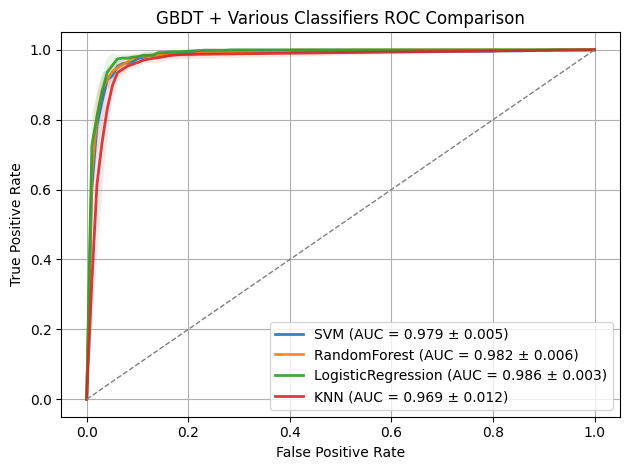

In [34]:
for name, (clf, param_grid) in classifiers.items():

    print(f" Running GBDT + {name} classifier...")

    pipeline = Pipeline([
        ('scaler', StandardScaler(with_mean=False)),
        ('clf', clf)
    ])

    grid = GridSearchCV(pipeline, param_grid, cv=3)

    tprs, aucs = [], []
    mean_fpr = np.linspace(0, 1, 100)
    roc_auc_scores = []
    scores = []
    i = 0

    for train_index, test_index in stratified_k_fold.split(selected_data_np, selected_label_np):
        X_train, X_test = selected_data_np[train_index], selected_data_np[test_index]
        y_train, y_test = selected_label_np[train_index], selected_label_np[test_index]

        X_train_trans = OHE.transform(GBDT.apply(X_train)[:, :, 0])
        X_test_trans = OHE.transform(GBDT.apply(X_test)[:, :, 0])

        grid.fit(X_train_trans, y_train)
        predicted_probs = grid.predict_proba(X_test_trans)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, predicted_probs)
        roc_auc = auc(fpr, tpr)


        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        aucs.append(roc_auc)

        roc_auc_scores.append(roc_auc)
        scores.append(grid.score(X_test_trans, y_test))
        i += 1

        print(f"  Fold {i} : ROC AUC: {roc_auc:.4f} Accuracy: {grid.score(X_test_trans, y_test):.4f}")

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)

    plt.plot(
        mean_fpr,
        mean_tpr,
        label=f'{name} (AUC = {mean_auc:.3f} ± {std_auc:.3f})',
        lw=2,
        alpha=0.9
    )

    std_tpr = np.std(tprs, axis=0)
    tpr_upper = np.minimum(mean_tpr + std_tpr, 1)
    tpr_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tpr_lower, tpr_upper, alpha=0.1)

    print(f"{name} Mean ROC AUC: {mean_auc:.4f}")
    print(f"{name} Mean Accuracy: {np.mean(scores):.4f}")


plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('GBDT + Various Classifiers ROC Comparison')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()
